In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
%matplotlib qt 
import hyperspy.api as hs

In [22]:
#img_path = "output/CNS_2obj_1slice_1e-3_2configs_random_b64/objp_iter0200.tif"

img_path = "output/multi_obj_WSe2_and_Cu_4obj_1slice_1e-3_dppow0.5_b64/objp_iter0100.tif"
#img_path = "output/CNS_1obj_1slice_1e-3_revisit/objp_iter0500_5e-4_dppow0.5.tif"
#img_path = "output/CNS_32obj_1slice_5e-4_revisit/objp_iter0500.tif"
#img_path = "output/abtem/potential_256_phonon_0.1_std_zsum_dx0.08Ang.tif"
img = imread(img_path)
img.shape

(4, 514, 494)

In [23]:
# window = 144
# img_crop = img[:,202-window//2:202+window//2, 201-window//2:201+window//2]

window = 144
img_crop = img[:,202-window//2:202+window//2, 201-window//2:201+window//2]

fig, axs = plt.subplots(1,2)
im00 = axs[0].imshow(np.mean(img_crop, 0))
fig.colorbar(im00, shrink=0.6)
axs[0].set_title(f'Mean image (N={len(img_crop)})')
im01 = axs[1].imshow(np.std(img_crop,0))
fig.colorbar(im01, shrink=0.6)
axs[1].set_title(f'Std image (N={len(img_crop)})')

plt.show()

# Atomap fitting / model

In [94]:
import atomap.api as am

s = hs.signals.Signal2D(canvas)
s_peaks = am.get_feature_separation(s, separation_range=(5, 7), show_progressbar=False)
s_peaks.plot()

In [95]:
atom_positions = am.get_atom_positions(s, separation=6)
sublattice = am.Sublattice(atom_positions, image=s.data)

sublattice.find_nearest_neighbors()
sublattice.refine_atom_positions_using_center_of_mass()
sublattice.refine_atom_positions_using_2d_gaussian(mask_radius=4)

model_image = sublattice.get_model_image()
s.plot(title='Data')
model_image.plot(title='Model')
(s-model_image).plot(title='Difference', cmap='seismic', vmin=-0.2, vmax=0.2)

Center of mass:   0%|          | 0/525 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

In [104]:
plt.figure()
plt.hist(sublattice.atom_amplitude_gaussian2d.ravel(), bins=100)
plt.show()

In [106]:
import numpy as np
import matplotlib.pyplot as plt


def generate_gaussian(A, x, y, sx, sy, rotation, size):
    # Generate a grid of coordinates
    xx, yy = np.meshgrid(np.arange(size[1]), np.arange(size[0]))

    # Rotation parameters
    x0 = x
    y0 = y
    theta = rotation 

    # Calculate terms used in the Gaussian function
    sx2 = sx ** 2
    sy2 = sy ** 2
    cos_theta2 = np.cos(theta) ** 2
    sin_theta2 = np.sin(theta) ** 2
    sin_2theta = np.sin(2 * theta)

    a = cos_theta2 / (2 * sx2) + sin_theta2 / (2 * sy2)
    b = -sin_2theta / (4 * sx2) + sin_2theta / (4 * sy2)
    c = sin_theta2 / (2 * sx2) + cos_theta2 / (2 * sy2)

    # Apply rotation and generate Gaussian blob
    x_rot = xx - x0
    y_rot = yy - y0
    gaussian_blob = (
        A
        * (1 / (sx * sy * (2 * np.pi)))
        * np.exp(-(
            a * (x_rot ** 2) + 
            2 * b * (x_rot * y_rot) + 
            c * (y_rot ** 2)
        ))
    )

    return gaussian_blob

def generate_canvas(gaussian_params, canvas_size):
    canvas = np.zeros(canvas_size)
    for params in gaussian_params:
        A, x, y, sx, sy, rotation = params
        gaussian_blob = generate_gaussian(A, x, y, sx, sy, rotation, canvas_size)
        canvas += gaussian_blob
    return canvas

canvas_size = s.data.shape

shift_vec = np.zeros((len(sublattice.atom_list),2)) # np.random.normal(0, 1, size=(len(sublattice.atom_list), 2))
target_indices = np.where(sublattice.atom_amplitude_gaussian2d<7.5)[0]
shift_vec[target_indices] = np.random.normal(0, 1.66, size=(len(target_indices), 2))

sigma_shrink = np.ones(len(sublattice.atom_list))
sigma_shrink[target_indices] = 0.5

# Example Gaussian parameters (x, y, sx, sy, rotation)
gaussian_params = [(sublattice.atom_amplitude_gaussian2d[i],
                    sublattice.x_position[i] ,
                    sublattice.y_position[i] + shift_vec[i,0],
                    sublattice.sigma_x[i] * sigma_shrink[i],
                    sublattice.sigma_y[i] * sigma_shrink[i],
                    sublattice.rotation[i]) for i in range(len(sublattice.atom_list))]



# Generate canvas with Gaussian blobs
perturbed_model = generate_canvas(gaussian_params, canvas_size)

# Plot canvas with Gaussian blobs
plt.figure(figsize=(8, 6))
plt.imshow(model_image, cmap='gray')
plt.title('Model')
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(perturbed_model, cmap='gray')
plt.title('perturbed_model')
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.title("Model - perturbed model")
plt.imshow(model_image - perturbed_model, cmap='seismic', vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.axis('off')
plt.show()


In [119]:
# Generate an image stack

omode = 64
imstack = np.zeros((omode,1,391,403), dtype='float32')
target_indices = np.where(sublattice.atom_amplitude_gaussian2d<7.5)[0]
sigma_shrink = np.ones(len(sublattice.atom_list))
sigma_shrink[target_indices] = 0.5

# Prepopulate the gaussian_params
gaussian_params = np.zeros((len(sublattice.atom_list), 6))

for i in range(len(sublattice.atom_list)):
    gaussian_params[i] = (sublattice.atom_amplitude_gaussian2d[i],
                        sublattice.x_position[i],
                        sublattice.y_position[i],
                        sublattice.sigma_x[i],
                        sublattice.sigma_y[i],
                        sublattice.rotation[i])

for ii in range(omode):
    print(f"Generating {ii}")
    shift_vec = np.zeros((len(sublattice.atom_list),2)) # np.random.normal(0, 1, size=(len(sublattice.atom_list), 2))
    shift_vec[target_indices] = np.random.normal(0,1.66, size=(len(target_indices), 2))
    
    perturbed_gaussian_params = gaussian_params.copy()
    #perturbed_gaussian_params[target_indices,1] += shift_vec[target_indices,1] # x_pos
    perturbed_gaussian_params[target_indices,2] += shift_vec[target_indices,0] # y_pos 
    perturbed_gaussian_params[target_indices,3] *= sigma_shrink[target_indices]
    perturbed_gaussian_params[target_indices,4] *= sigma_shrink[target_indices] 

    imstack[ii,0] = generate_canvas(perturbed_gaussian_params, canvas_size)

Generating 0
Generating 1
Generating 2
Generating 3
Generating 4
Generating 5
Generating 6
Generating 7
Generating 8
Generating 9
Generating 10
Generating 11
Generating 12
Generating 13
Generating 14
Generating 15
Generating 16
Generating 17
Generating 18
Generating 19
Generating 20
Generating 21
Generating 22
Generating 23
Generating 24
Generating 25
Generating 26
Generating 27
Generating 28
Generating 29
Generating 30
Generating 31
Generating 32
Generating 33
Generating 34
Generating 35
Generating 36
Generating 37
Generating 38
Generating 39
Generating 40
Generating 41
Generating 42
Generating 43
Generating 44
Generating 45
Generating 46
Generating 47
Generating 48
Generating 49
Generating 50
Generating 51
Generating 52
Generating 53
Generating 54
Generating 55
Generating 56
Generating 57
Generating 58
Generating 59
Generating 60
Generating 61
Generating 62
Generating 63


In [116]:
hs.signals.Signal2D(imstack[:,0]).plot()
data_arr = np.array(hs.signals.Signal2D(imstack[:,0]))

In [117]:
plt.figure()
plt.imshow(data_arr.mean(0))

In [121]:
from tifffile import imwrite
imwrite("output/CNS_64obj_initial_guess_16bit.tif", np.uint16(65535*(data_arr - data_arr.min())/(data_arr.max() - data_arr.min())))
imwrite("output/CNS_64obj_initial_guess_32bit.tif", data_arr)


# hyerspy for SVD approaches

In [28]:
s = hs.signals.Signal2D(img_crop)
s.plot()
s.decomposition(algorithm="SVD", centre='signal', output_dimension=4) # Default is SVD, other options: PCA, MLPCA, RPCA, ORPCA, NMF, ORNMF,  
s.plot_explained_variance_ratio() 
s.plot_decomposition_results()

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=4
  centre=signal


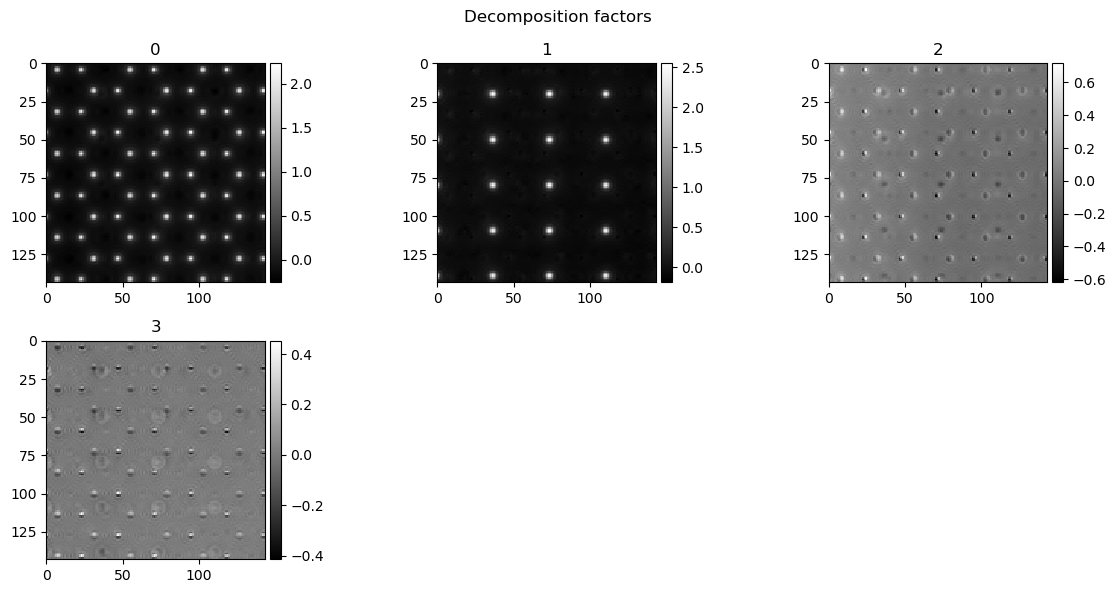

In [29]:
s.plot_decomposition_factors(4)

In [30]:
sm = s.get_decomposition_model(components=2)
sm.plot(title='model')
(s-sm).plot(cmap='seismic', title='difference')

In [14]:
s.get_decomposition_model()

<Signal2D, title:  model from decomposition with 2 components, dimensions: (4|144, 144)>

In [ ]:
data_arr = np.array(s.data)
model_arr = np.array(sm)

In [ ]:
imwrite("output/CNS_64obj_5e-4_random/CNS_64obj_5e-4_random_16bit.tif", np.uint16(65535*(data_arr - data_arr.min())/(data_arr.max() - data_arr.min())))
imwrite("output/CNS_64obj_5e-4_random/CNS_64obj_5e-4_random_SVD_3_of_13comp_16bit.tif", np.uint16(65535*(model_arr - model_arr.min())/(model_arr.max() - model_arr.min())))

In [ ]:
from tifffile import imwrite
sm_arr = np.array(sm)
imwrite("output/CNS_10obj_1e-4_random/CNS_10obj_1e-4_random_SVD_3_of_10comp.tif", np.float32(sm_arr))
imwrite("output/CNS_10obj_1e-4_random/CNS_10obj_1e-4_random_SVD_3_of_10comp_16bit.tif", np.uint16(65535*(sm_arr - sm_arr.min())/(sm_arr.max() - sm_arr.min())))

# PiecewiseAffineTransform

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp, PiecewiseAffineTransform
from skimage.feature import blob_log

canvas = img[0]# (img[0] - img[0].min()) / (img[0].max() - img[0].min())

# Generate random filled circles on a black canvas
canvas_size = canvas.shape
np.random.seed(0)

# Plot original image with random circles
plt.figure(figsize=(8, 6))
plt.imshow(canvas, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Identify control points by detecting corners
control_points = blob_log(canvas, max_sigma=5, num_sigma=10, threshold=.04, exclude_border = 50)[:,:2]

# Plot original image with control points
plt.figure(figsize=(8, 6))
plt.imshow(canvas, cmap='gray')
plt.plot(control_points[:, 1], control_points[:, 0], 'ro')
plt.title('Original Image with Control Points')
plt.axis('off')
plt.show()

# Assign each control point a random warping vector
warp_vectors = np.random.normal(0, 1, size=(len(control_points), 2))

# Create a PiecewiseAffineTransform object
transform = PiecewiseAffineTransform()

# Add control points and their corresponding displaced points to the transform object
src, dst = control_points, control_points + warp_vectors
transform.estimate(src, dst)

# Apply the warp transformation to the image
warped_image = warp(canvas, transform, output_shape=canvas.shape)

# Plot warped image
plt.figure(figsize=(8, 6))
plt.imshow(warped_image, cmap='gray')
plt.title('Warped Image')
plt.axis('off')
plt.show()

# Plot difference image
plt.figure(figsize=(8, 6))
plt.imshow(warped_image - canvas, cmap='seismic', vmin=-0.5, vmax=0.5)
plt.title('Difference Image')
plt.axis('off')
plt.show()


C:\Users\chiahao3\AppData\Local\Temp\ipykernel_23228\2226737002.py:38: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  transform.estimate(src, dst)
